<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/Tips_tricks_22_fastai_lung_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=PHLZCL5h9dc

**Lung cancer subclassification using fastai**

LC25000 Lung and colon histopathological image dataset from: https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

**Dataset info:**

https://github.com/tampapath/lung_colon_image_set/

https://arxiv.org/ftp/arxiv/papers/1912/1912.12142.pdf


LC25000 LUNG AND COLON HISTOPATHOLOGICAL IMAGE DATASET

The dataset contains color 25,000 images with 5 classes of 5,000 images each. All images are 768 x 768 pixels in size and are in jpeg file format. Our dataset can be downloaded as a 1.85 GB zip file LC25000.zip. After unzipping, the main folder lung_colon_image_set contains two subfolders: colon_image_sets and lung_image_sets.


The subfolder lung_image_sets contains three secondary subfolders: lung_aca subfolder with 5000 images of lung adenocarcinomas, lung_scc subfolder with 5000 images of lung squamous cell carcinomas, and lung_n subfolder with 5000 images of benign lung tissues.

In [ ]:
# If the following warning message annoys you....
#UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries
#Install older version of torch 
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
import torch
print(torch.__version__)

1.4.0


In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
#You may already have this preinstalled and available on Colab
!pip install fastai

In [ ]:
from fastai.vision import get_transforms, ImageDataBunch, cnn_learner, ClassificationInterpretation, models 
from fastai.metrics import error_rate, accuracy

In [ ]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/data/lung_dataset/'

In [ ]:
#https://fastai1.fast.ai/vision.transform.html#get_transforms
tfms = get_transforms(do_flip=True, max_rotate=10.0, )

In [ ]:
# The transformers are already built into the model
# num_workers = how many subprocesses to use for data loading
data = ImageDataBunch.from_folder(image_directory, train='train', valid='val', ds_tfms=tfms, size=224, bs=64, num_workers=8)

In [ ]:
# Show what the data looks like after being transformed
data.show_batch()


In [ ]:
# See the classes and count of classes in your dataset
print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

['lung_aca', 'lung_n', 'lung_scc'] 3
11250 2250


cnn_learner can be used to build a convnet style model. You can pass the dataset and architecture information. The number of final activations (classes) is inferred from the data or can be explicitly provided. 

Documentation from here: https://docs.fast.ai/vision.learner.html#cnn_learner

You can create Unet models for semantic segmentation.

create_unet_model or unet_learner (for custom unet architecture)

In [ ]:
#To find out all available vision models 
dir(models)
#We will use resnet34. By default it downloads Imagenet pretrained weights. 

In [ ]:
# Build the CNN model with the pretrained resnet34
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

By default all layers are frozen except for the last layer, classifier layer. When we train the model using fit_one_cycle it only trains the last layer. If we want all layers to be trainable, we need to unfreeze the model using learn.unfreeze()

In [ ]:
# Unfreeze all layers of the CNN
learn.unfreeze()

In [ ]:
# Find the optimal learning rate and plot a visual
# Explore lr from start_lr to end_lr over num_it iterations in learn.
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.00E-02


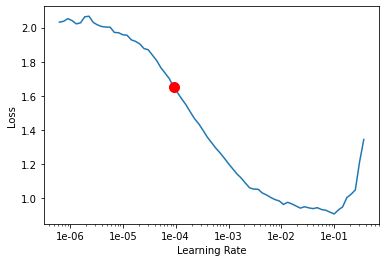

In [ ]:
#Then we plot the loss versus the learning rates. 
# we choose a value that is approximately in the middle of the sharpest downward slope.
# Picking a value before the downward slope results in slow training:
learn.recorder.plot(suggestion=True)

 **Fit the model**

Make sure to use discriminative learning rates here(parameter max_lr), which maintains a low learning rate for initial layers as they need lesser tuning and gradually increase learning rate for later layers which need higher tuning especially fully connected ones.

In [ ]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.296926,0.057571,0.978667,06:46
1,0.127632,0.035259,0.986667,06:49


In [ ]:
# Save the model
learn.save('/content/drive/MyDrive/Colab Notebooks/data/lung_dataset/models/lung_cancer_classifier')


In [ ]:
# Load the Model
learn.load('/content/drive/MyDrive/Colab Notebooks/data/lung_dataset/models/lung_cancer_classifier')

In [ ]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model made the worse predictions:
interp = ClassificationInterpretation.from_learner(learn)

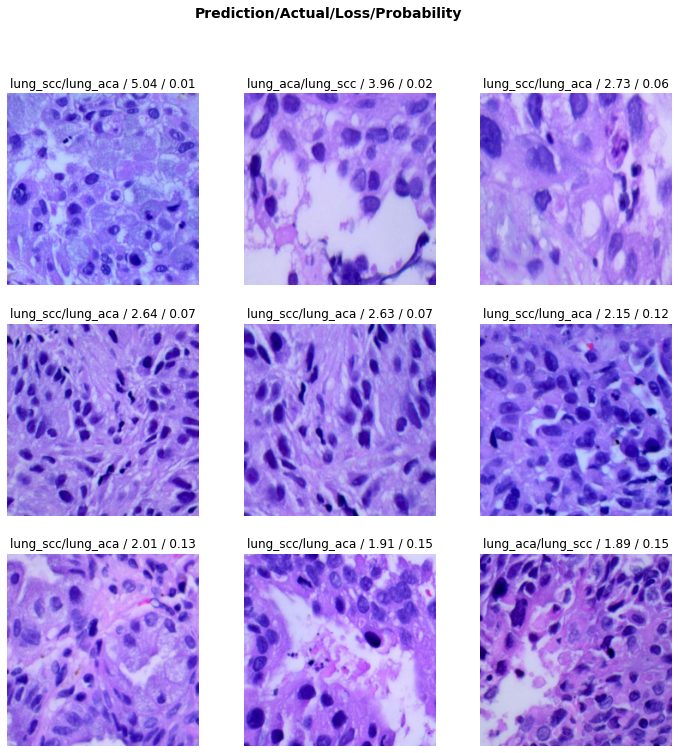

In [ ]:
# Plot the top ‘n’ classes where the classifier has least precision.
interp.plot_top_losses(9, figsize=(12,12), heatmap=False)

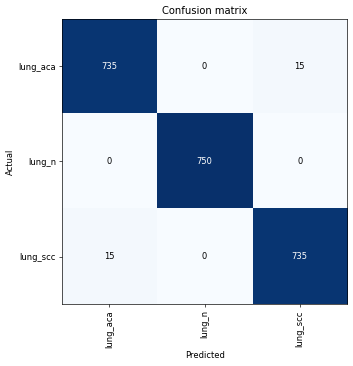

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
#To view the list of classes most misclassified as a list
interp.most_confused(min_val=2) #We are ignoring single image misclassification

#Sorted descending list of largest non-diagonal entries of confusion matrix, 
#presented as actual, predicted, number of occurrences.

[('lung_aca', 'lung_scc', 15), ('lung_scc', 'lung_aca', 15)]